In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Define the path to your dataset
#change according to your file directory
data_path = r"./Dataset_1/Dataset_1/Colorectal_Cancer "

reason for mean and STD initialization 
check out this discussion: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2


In [2]:
# Transformation pipeline: Resize all images to be of the same size
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using ImageNet mean and STD
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes  # List of class names inferred from folder names
print(f"Labels: {class_names}")

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Labels: ['MUS', 'NORM', 'STR']


In [3]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


(tensor([[[ 0.2111,  0.5193,  1.3927,  ..., -0.0801, -0.2684,  0.0912],
         [-0.2684, -0.1314,  1.3755,  ..., -0.3369, -0.5938, -0.1486],
         [-0.1828,  0.2453,  1.9749,  ...,  0.0056, -0.3198, -0.2513],
         ...,
         [ 0.6221,  0.8618,  1.0673,  ...,  0.9132,  1.4098,  1.3413],
         [ 0.6392,  0.9474,  1.0673,  ...,  1.0159,  1.1187,  1.1700],
         [ 0.5022,  0.8447,  1.1187,  ...,  1.4783,  1.2385,  1.0844]],

        [[-0.4776, -0.2675,  0.4678,  ..., -0.7577, -0.8627, -0.5301],
         [-0.9853, -0.8452,  0.4503,  ..., -0.8277, -1.1604, -0.8978],
         [-0.7927, -0.5301,  0.8004,  ..., -0.6527, -1.0203, -0.9153],
         ...,
         [-0.2150,  0.0301, -0.0049,  ..., -0.1625,  0.2927,  0.2752],
         [-0.3550, -0.0224, -0.0224,  ...,  0.1877,  0.0826,  0.2227],
         [-0.5651, -0.1975, -0.0224,  ...,  0.9055,  0.4153,  0.1352]],

        [[ 0.9145,  1.0365,  1.8034,  ...,  0.6531,  0.4439,  1.0191],
         [ 0.3916,  0.4962,  1.7337,  ...,  

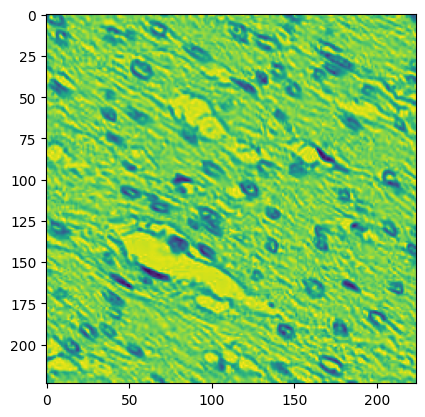

In [4]:
#Visualize some pics
image , label = dataset[0]
print(dataset[0])  # Check what this returns

# image = cv2.imread(image)
plt.imshow(image[0])

In [5]:
# Load the ResNet-18 model with no pre-trained weights
model = models.resnet18()

# Modify the final layer to match the number of classes (3 in this case: MUS, NORM, STR)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss function (Cross-Entropy Loss) and optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Training function for ResNet-18 model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate validation loss and accuracy
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        # Compute average loss and accuracy for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return model

In [7]:
# Train the model with specified number of epochs
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6106 Acc: 0.7323
Val Loss: 0.4480 Acc: 0.8008
Epoch 1/9
----------
Train Loss: 0.3575 Acc: 0.8623
Val Loss: 0.3302 Acc: 0.8742
Epoch 2/9
----------
Train Loss: 0.2726 Acc: 0.8979
Val Loss: 0.2604 Acc: 0.9067
Epoch 3/9
----------
Train Loss: 0.1955 Acc: 0.9290
Val Loss: 0.2478 Acc: 0.9058
Epoch 4/9
----------
Train Loss: 0.1690 Acc: 0.9323
Val Loss: 0.4235 Acc: 0.8733
Epoch 5/9
----------
Train Loss: 0.1529 Acc: 0.9458
Val Loss: 0.3471 Acc: 0.8517
Epoch 6/9
----------
Train Loss: 0.1159 Acc: 0.9581
Val Loss: 0.2014 Acc: 0.9267
Epoch 7/9
----------
Train Loss: 0.1134 Acc: 0.9583
Val Loss: 0.1080 Acc: 0.9633
Epoch 8/9
----------
Train Loss: 0.0896 Acc: 0.9692
Val Loss: 0.2141 Acc: 0.9117
Epoch 9/9
----------
Train Loss: 0.0868 Acc: 0.9656
Val Loss: 0.0861 Acc: 0.9708


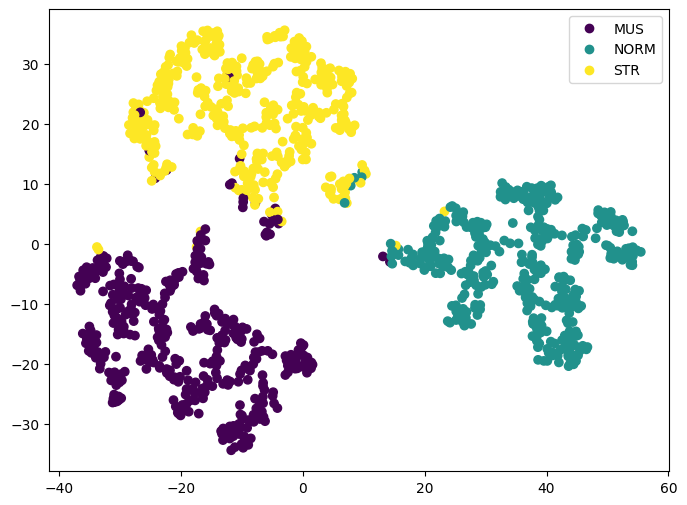

In [8]:
# Function to extract features from the penultimate layer
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get the output from the final layer
            features.append(outputs.cpu().numpy())  # Store the logits
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from validation dataset
features, labels = extract_features(model, val_loader)

# Perform t-SNE to reduce features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.show()

## Part 2 starts here

### Loading Datasets 2 and 3

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to your datasets
data_path_2 = "./Dataset_2/Dataset_2/Prostate_Cancer"
data_path_3 = "./Dataset_3/Dataset_3/Animal_Faces"

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets
dataset_2 = datasets.ImageFolder(root=data_path_2, transform=transform)
dataset_3 = datasets.ImageFolder(root=data_path_3, transform=transform)

# Create DataLoaders
batch_size = 32
loader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=False)
loader_3 = DataLoader(dataset_3, batch_size=batch_size, shuffle=False)

# Print class names
class_names_2 = dataset_2.classes
class_names_3 = dataset_3.classes
print(f"Dataset 2 Labels: {class_names_2}")
print(f"Dataset 3 Labels: {class_names_3}")

Dataset 2 Labels: ['gland', 'nongland', 'tumor']
Dataset 3 Labels: ['cat', 'dog', 'wild']


### Load the Pre-Trained CNN Encoder from Task 1

In [10]:
model_task1 = model
model_task1.eval()

# Remove the classification head
encoder_task1 = nn.Sequential(*list(model_task1.children())[:-1])

### Load a Pre-trained ImageNet CNN Encoder

In [11]:
# Load a pre-trained ResNet-18 model
model_imagenet = models.resnet18(pretrained=True)
# model_imagenet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_imagenet.eval()

# Remove the classification head
encoder_imagenet = nn.Sequential(*list(model_imagenet.children())[:-1])


/home/hisham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hisham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for param_task1, param_imagenet in zip(encoder_task1.parameters(), encoder_imagenet.parameters()):
    if not torch.equal(param_task1.to(device), param_imagenet.to(device)):
        print("The encoders are different.")
        break
else:
    print("The encoders have identical weights.")


The encoders are different.


In [13]:
print(encoder_task1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
print(encoder_imagenet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Extract both features using Both encoders

In [15]:
def extract_features(encoder, dataloader, device):
    encoder.to(device)
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = encoder(inputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract features for Dataset 2
features_task1_2, labels_2 = extract_features(encoder_task1, loader_2, device)
features_imagenet_2, labels_2 = extract_features(encoder_imagenet, loader_2, device)

# Extract features for Dataset 3
features_task1_3, labels_3 = extract_features(encoder_task1, loader_3, device)
features_imagenet_3, labels_3 = extract_features(encoder_imagenet, loader_3, device)

In [16]:
print(features_task1_2.shape, features_imagenet_2.shape)
print(features_task1_3.shape, features_imagenet_3.shape)

(6000, 512) (6000, 512)
(6000, 512) (6000, 512)


In [17]:
print(features_task1_2[:5])
print(features_imagenet_2[:5])

[[2.327926   1.8422154  0.56950396 ... 0.6536347  0.31208846 0.30133945]
 [1.343604   1.5802144  0.32425633 ... 0.75348693 0.26433232 0.49107224]
 [1.8275895  1.9725093  0.31418926 ... 0.64714265 0.2498197  0.3374368 ]
 [1.6008674  2.0932178  0.20517617 ... 1.2843778  0.35832176 0.55429244]
 [1.591276   1.7241529  0.51064414 ... 0.5895814  0.40381324 0.35347733]]
[[1.366807   0.23646708 0.         ... 1.270624   0.02315925 0.47657323]
 [0.37145367 0.04956285 0.         ... 0.60407287 0.         0.5184556 ]
 [1.1110228  0.18867142 0.02703746 ... 1.2968996  0.10725048 0.29769892]
 [0.37899372 0.05987241 0.08290069 ... 1.4373235  0.23116891 0.58286244]
 [0.27316794 0.01114083 0.1378919  ... 1.7043254  0.13903019 0.19896682]]


### Apply t-SNE for Visualization

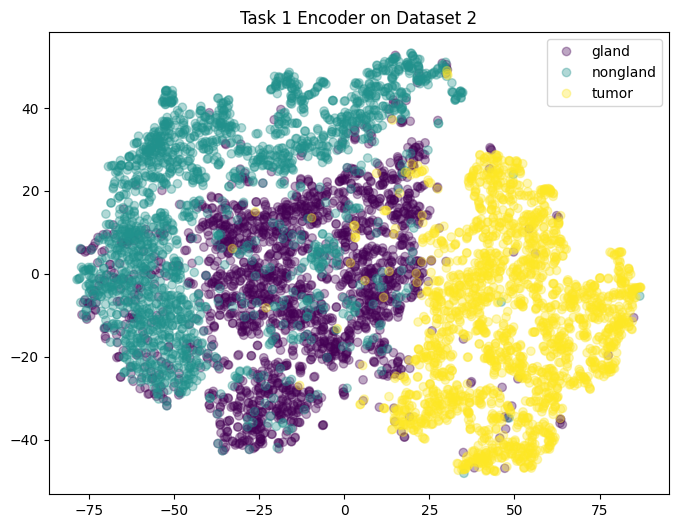

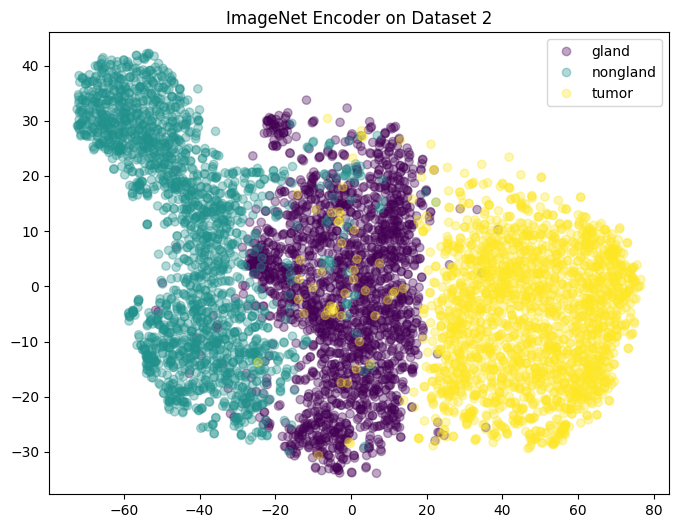

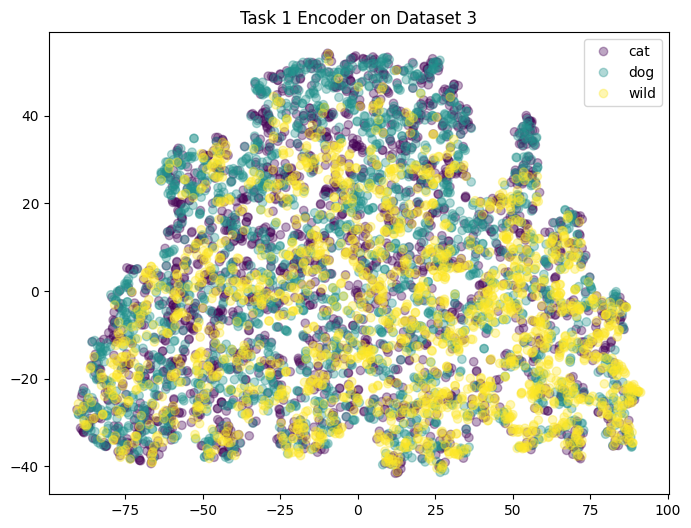

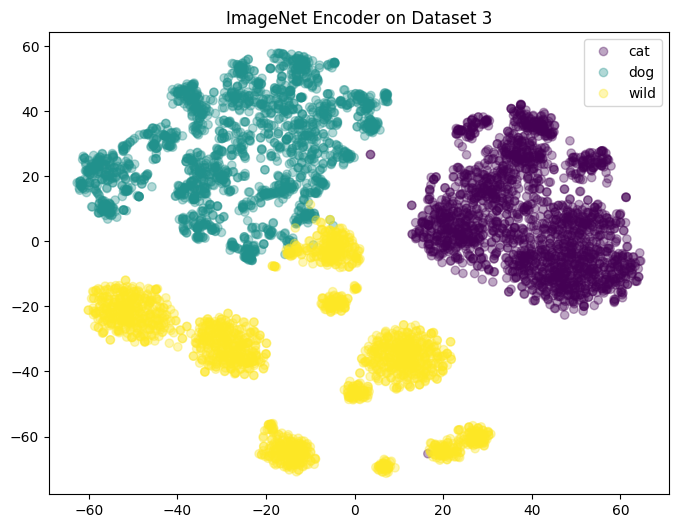

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.35)
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
    plt.title(title)
    plt.show()

# Plot t-SNE for Dataset 2
plot_tsne(features_task1_2, labels_2, "Task 1 Encoder on Dataset 2", class_names_2)
plot_tsne(features_imagenet_2, labels_2, "ImageNet Encoder on Dataset 2", class_names_2)

# Plot t-SNE for Dataset 3
plot_tsne(features_task1_3, labels_3, "Task 1 Encoder on Dataset 3", class_names_3)
plot_tsne(features_imagenet_3, labels_3, "ImageNet Encoder on Dataset 3", class_names_3)

### Classify extracted features

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def classify_features(features, labels):
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

# Classify features for Dataset 2 using Task 1 encoder
classify_features(features_imagenet_2, labels_2)

# Classify features for Dataset 3 using ImageNet encoder
classify_features(features_imagenet_3, labels_3)

Accuracy: 0.9517
Classification Report:
              precision    recall  f1-score   support

         MUS       0.93      0.94      0.94       437
        NORM       0.95      0.94      0.94       380
         STR       0.98      0.97      0.98       383

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

Accuracy: 0.9958
Classification Report:
              precision    recall  f1-score   support

         MUS       1.00      1.00      1.00       437
        NORM       0.99      0.99      0.99       380
         STR       0.99      1.00      0.99       383

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

